In [1]:
# %matplotlib inline
%matplotlib notebook

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

import os
import warnings
import copy

import numpy as np
import pandas as pd

from scipy import interpolate
from astropy.table import Table, Row, Column
from matplotlib import pyplot as plt
from lmfit import minimize, Parameters, fit_report

from collections import OrderedDict

import pycoco as pcc

Scale Factor 4.90620409684e+15
norm factor 3.93988
scaled 
[[Fit Statistics]]
    # function evals   = 13
    # data points      = 4
    # variables        = 4
    chi-square         = 0.000
    reduced chi-square = inf
    Akaike info crit   = -282.651
    Bayesian info crit = -285.106
[[Variables]]
    BessellB:   1.09659241 +/- inf      (inf%) (init= 1)
    BessellV:   0.67514826 +/- inf      (inf%) (init= 0.6906056)
    BessellR:   0.66740781 +/- inf      (inf%) (init= 0.6465052)
    BessellI:   0.69670070 +/- inf      (inf%) (init= 0.7398248)


<IPython.core.display.Javascript object>


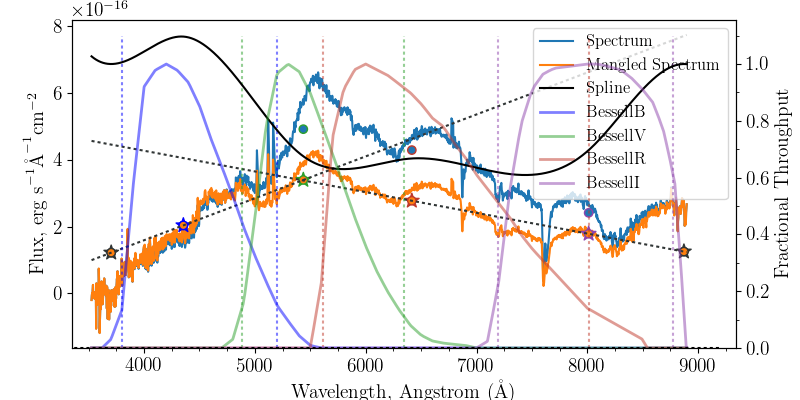

In [2]:
snname = "SN2006aj"
filters = ["BessellB", "BessellV", "BessellR", "BessellI"]

spec_filename = "SN2006aj_vlt_2006_03_10_z0.dat"
spec_mjd = 53803.68

verbose = False
plot = True
sn = pcc.classes.SNClass(snname)
sn.load_phot(verbose=False)
sn.load_list("/Users/berto/Code/CoCo/lists/" + snname + ".list")
sn.load_spec()
sn.get_lcfit("/Users/berto/Code/CoCo/recon/" + snname + ".dat")
sn.check_overlaps()

spec_dir = "/Users/berto/Code/CoCo/data/spec/" + snname + "/"

# for spec in list:

S = pcc.SpectrumClass()
S.load(filename=spec_filename, directory=spec_dir)

# filters = ["SDSS_g", "SDSS_r", "SDSS_i","SDSS_z"]

rows = OrderedDict()
filter_dict = OrderedDict()

for i, f in enumerate(filters):
    filter_dict[f] = pcc.kcorr.load_filter(os.path.join(pcc.defaults._default_filter_dir_path, f + ".dat"))
    filter_dict[f].calculate_edges()
    #     filter_dict[f].calculate_edges_zero()

    fit_flux = sn.lcfit.spline[f](spec_mjd)

    sn.phot.data_filters[f].resample_response(new_wavelength=S.wavelength)
    S_filter_flux = pcc.calc_spectrum_filter_flux(filter_object=sn.phot.data_filters[f], spectrum_object=S)
    S_filter_flux_no_area = pcc.calc_spectrum_filter_flux(filter_object=sn.phot.data_filters[f], spectrum_object=S,
                                                          correct_for_area=False)
    mS_filter_flux = np.NaN

    rows[f] = (fit_flux, S_filter_flux, S_filter_flux_no_area)
    if i == 0:
        data_table = Table(names=("filter", "fitflux", "spec_filterflux", "mangledspec_filterflux", "filter_object", "mask"),
            dtype=('S12', 'f4', 'f4', 'f4', object, bool))
    data_table.add_row((f, fit_flux, S_filter_flux, mS_filter_flux, filter_dict[f], True))

for i, f in enumerate(data_table["filter_object"]):
    ## Test extent
    bool_uncontained = np.logical_or(f._lower_edge < S.min_wavelength, f._upper_edge > S.max_wavelength)
    if verbose: print(bool_uncontained)
    if bool_uncontained:
        data_table = data_table[np.where(data_table["filter"] != pcc.utils.b(f.filter_name))]

knot_colours = [j._plot_colour for j in data_table["filter_object"] if hasattr(j, "_plot_colour")]
data_table.add_column(Column(knot_colours, name="knot_colours"))
data_table["lambda_eff"] = [i.lambda_effective.value for i in data_table["filter_object"]]
data_table

## Normalise data_table
# "wanted flux"
w = 0
scale_factor = 1. / data_table[w]["fitflux"]
print("Scale Factor", scale_factor)
norm_factor = data_table[w]["fitflux"] / data_table[w]["spec_filterflux"]
print("norm factor", norm_factor)
data_table["fitflux"] = data_table["fitflux"] * scale_factor
# "spec flux"
data_table["spec_filterflux"] = data_table["spec_filterflux"] * scale_factor
print("scaled ",)
nS = copy.deepcopy(S)
S.flux = S.flux * scale_factor
S.flux = S.flux * norm_factor
S.scale_factor = scale_factor
S.norm_factor = norm_factor
data_table
data_table["spec_filterflux"] = data_table["spec_filterflux"] * norm_factor

anchor_min_wavelength = np.nanmin([i._lower_edge for i in data_table["filter_object"]]) - 100
anchor_max_wavelength = np.nanmax([i._upper_edge for i in data_table["filter_object"]]) + 100

c_lower, m_lower, c_upper, m_upper = pcc.calc_linear_terms(data_table)

spl_wav = S.data['wavelength'][np.logical_and(S.data['wavelength'] >= anchor_min_wavelength, S.data['wavelength'] <= anchor_max_wavelength)]

data_table.add_row(("lower_anchor", anchor_min_wavelength * m_lower + c_lower, anchor_min_wavelength * m_lower + c_lower,
                   anchor_min_wavelength * m_lower + c_lower, np.nan, False,
                   pcc.hex["batman"], anchor_min_wavelength))
data_table.add_row(("upper_anchor", anchor_max_wavelength * m_upper + c_upper, anchor_max_wavelength * m_upper + c_upper,
                   anchor_max_wavelength * m_upper + c_upper, np.nan, False,
                   pcc.hex["batman"], anchor_max_wavelength))

orig_data_table = data_table

data_table.add_index("lambda_eff")
data_table.sort()
data_table

for i, f in enumerate(data_table["filter_object"]):
    if isinstance(f, pcc.classes.FilterClass):
        mangledspec_filterflux = pcc.calc_spectrum_filter_flux(filter_object=f, spectrum_object=S)
#         print(data_table["spec_filterflux"][i], mangledspec_filterflux)
        data_table["mangledspec_filterflux"][i] = mangledspec_filterflux
    else:
        pass
data_table

original_spectrum_flux = data_table[data_table["mask"]]["spec_filterflux"].data
scaled_spectrum_flux = data_table[data_table["mask"]]["mangledspec_filterflux"].data
wanted_flux = data_table[data_table["mask"]]["fitflux"].data
wanted_filters = data_table[data_table["mask"]]["filter_object"].data

if len(scaled_spectrum_flux) == len(wanted_flux):
    params = Parameters()
    for i, flux_tuple in enumerate(zip(scaled_spectrum_flux, wanted_flux)):
        params.add(wanted_filters[i].filter_name, value=flux_tuple[1] / flux_tuple[0])

    out = minimize(pcc.manglemin, params, args=(S, data_table), kws=({"verbose":False}))
    
    print(fit_report(out))
    

    paramlist = np.array([out.params[key].value for key in out.params.keys()])
    weights = np.append(np.append(1.0, paramlist), 1.0)
    final_spl = interpolate.CubicSpline(data_table["lambda_eff"], weights, bc_type = "clamped")
    mS = copy.deepcopy(S)
    mS.flux = mS.flux*final_spl(mS.wavelength)

    verbose = False
    for i, f in enumerate(data_table["filter_object"]):
        if isinstance(f, pcc.classes.FilterClass):
            mangledspec_filterflux = pcc.calc_spectrum_filter_flux(filter_object=f, spectrum_object=mS)
            if verbose: print(data_table["spec_filterflux"][i], data_table["fitflux"][i], mangledspec_filterflux)
            data_table["mangledspec_filterflux"][i] = mangledspec_filterflux
    

    mS.flux = mS.flux/mS.scale_factor
    S.flux = S.flux/S.scale_factor
    final_data_table = data_table
    
    final_data_table["fitflux"] = final_data_table["fitflux"]/S.scale_factor
    final_data_table["spec_filterflux"] = final_data_table["spec_filterflux"]/S.scale_factor
    final_data_table["mangledspec_filterflux"] = final_data_table["mangledspec_filterflux"]/S.scale_factor
    c_lower, m_lower, c_upper, m_upper = pcc.calc_linear_terms(final_data_table)
    
    pcc.plot_mangledata(S, data_table, mS=mS, spl = final_spl, show_linear_extrap=True,
                c_upper=c_upper, c_lower=c_lower, m_upper=m_upper, m_lower=m_lower,ylim=False)
    
    

In [3]:
data_table[data_table["mask"]]

filter,fitflux,spec_filterflux,mangledspec_filterflux,filter_object,mask,knot_colours,lambda_eff
bytes12,float32,float32,float32,object,bool,str7,float64
BessellB,2.03824e-16,2.03824e-16,2.03824e-16,<pycoco.classes.FilterClass object at 0x11324fba8>,True,#0000ff,4354.41054934
BessellV,3.39782e-16,4.92005e-16,3.39782e-16,<pycoco.classes.FilterClass object at 0x1135e3b38>,True,#2ca02c,5436.8698117
BessellR,2.77561e-16,4.29326e-16,2.77561e-16,<pycoco.classes.FilterClass object at 0x11331bcc0>,True,#c0392b,6416.11806798
BessellI,1.78623e-16,2.4144e-16,1.78623e-16,<pycoco.classes.FilterClass object at 0x11331bb38>,True,#8e44ad,8011.65864198


In [4]:
[np.float64(i._lower_edge) for i in data_table["filter_object"][data_table["mask"]]]

[3803.1799674437539,
 4887.8786075848611,
 5610.7012292352365,
 7197.1601230177166]

In [5]:
final_spl(spl_wav)

array([ 1.00000434,  1.00001842,  1.00004217, ...,  0.99996893,
        0.99998966,  0.99999927])